In [2]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# datastructure to maintain the neural network parameters
class Tensor:
    def __init__(self, data, requires_grad=False, _children=(), _ops=[], label=None):
        self.data = np.array(data)
        self.requires_grad = requires_grad
        self.label = label
        self._backward = lambda: None # backward function
        self.grad = None
        self._creator = None
        self._ops = _ops # ops that use this tensor as an input
        self._children = set(_children)

    def __repr__(self):
        return "Tensor: data={}, requires_grad={}, grad={}".format(self.data, self.requires_grad, self.grad)

    def __add__(self, other):
        if self.requires_grad or other.requires_grad:
            out = Tensor(self.data + other.data, requires_grad=True, _children=(self, other), _ops="+")
            def backward():
                self.grad += out.grad
                other.grad += out.grad
            out._backward = backward
            return out

        return Tensor(self.data + other.data, _children=(self, other), _ops="+")

    def __sub__(self, other):
        if self.requires_grad or other.requires_grad:
            out = Tensor(self.data - other.data, requires_grad=True, _children=(self, other), _ops="-")
            def _backward():
                self.grad += out.grad
                other.grad += -out.grad
            out._backward = _backward
            return out
        return Tensor(self.data - other.data, _children=(self, other), _ops="-")  

    def __mul__(self, other):
        if not isinstance(other, Tensor):
            if self.requires_grad:
                out = Tensor(self.data * other, requires_grad=True, _children=(self,), _ops="*")
                def backward():
                    self.grad += out.grad * other
                out._backward = backward
                return out
            return Tensor(self.data * other, _children=(self,), _ops="*")
            
        if self.requires_grad or other.requires_grad:
            out = Tensor(self.data * other.data, requires_grad=True, _children=(self, other), _ops="*")
            def backward():
                self.grad += out.grad * other.data
                other.grad += out.grad * self.data
            out._backward = backward
            return out
        return Tensor(self.data * other.data, _children=(self, other), _ops="*")  

    def rmul(self, other):
        return self * other
    
    def pow(self, other):
        assert isinstance(other, int, float), "exponent must be a number"
        if self.requires_grad:
            out = Tensor(self.data ** other, requires_grad=True, _children=(self,), _ops="**")
            def backward():
                self.grad += out.grad * other * self.data ** (other - 1)
            out._backward = backward
            return out
        return Tensor(self.data ** other, _children=(self,), _ops="**")

    def __truediv__(self, other):
        if self.requires_grad or other.requires_grad:
            out = Tensor(self.data / other.data, requires_grad=True, _children=(self, other), _ops="/")
            def backward():
                self.grad += out.grad / other.data
                other.grad += -out.grad * self.data / other.data**2
            out._backward = backward
            return out
        return Tensor(self.data / other.data, _children=(self, other), _ops="/")
 
    def __matmul__(self, other):
        if self.requires_grad or other.requires_grad:
            return Tensor(self.data @ other.data, requires_grad=True, _children=(self, other), _ops="@")       
        return Tensor(self.data @ other.data, _children=(self, other), _ops="@")

    def sum(self):
        if self.requires_grad:
            return Tensor(self.data.sum(), requires_grad=True, _children=(self,), _ops="sum")
        return Tensor(self.data.sum(),  _children=(self,), _ops="sum")

    def expand(self, dim):
        shape = list(self.data.shape)
        shape.insert(dim, 1)
        return Tensor(self.data.reshape(shape))

    def transpose(self):
        return Tensor(self.data.T)
    
    def exp(self):
        if self.requires_grad:
            out = Tensor(np.exp(self.data), requires_grad=True, _children=(self,), _ops="exp")
            def _backward():
                self.grad += out.grad * out.data 
            out._backward = _backward
            return out 
        return Tensor(np.exp(self.data), _children=(self,), _ops="exp")
    
    def tanh(self):
        if self.requires_grad:
            out = Tensor(np.tanh(self.data), requires_grad=True, _children=(self,), _ops="tanh")
            def backward():
                self.grad += out.grad * (1 - out.data**2)
            return out
        return Tensor(np.tanh(self.data), _children=(self,), _ops="tanh")
    
    def backward(self):
        self.grad = np.ones_like(self.data)
        self._backward()
        for child in self._children:
            child.backward()
    

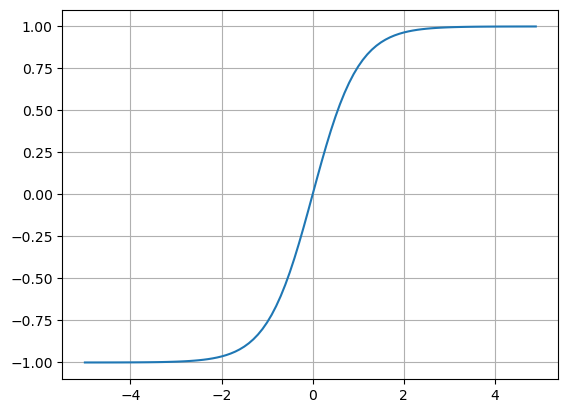

In [11]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1)),);plt.grid()

In [14]:
a = Tensor(3, label="a", requires_grad=True)

b = a + a; b.label="b"

b.backward()

In [16]:
b.grad

array(1)

In [17]:
a.grad

array(1)

In [19]:
a.grad

array(1)